# Robustness
In this example we analyze how robust feature selection with BINN is. All feature selection methods are data-greedy, meaning that we need many samples to generate robust estimations of feature importance. One way to analyze this is to train and explain several models, and compare their feature importances. This will also yield a more robust method.

In [1]:
from binn import BINN, BINNDataLoader, BINNTrainer
import pandas as pd

# Load your data
data_matrix = pd.read_csv("../data/sample_datamatrix.csv")
design_matrix = pd.read_csv("../data/sample_design_matrix.tsv", sep="\t")

# Initialize BINN
binn = BINN(data_matrix=data_matrix, network_source="reactome", n_layers=5, dropout=0.2)

## Initialize DataLoader
binn_dataloader = BINNDataLoader(binn)

# Create DataLoaders
dataloaders = binn_dataloader.create_dataloaders(
    data_matrix=data_matrix,
    design_matrix=design_matrix,
    feature_column="Protein",
    group_column="group",
    sample_column="sample",
    batch_size=32,
    validation_split=0.2,
)
# Train the model
trainer = BINNTrainer(binn)

from binn import BINNExplainer

explainer = BINNExplainer(binn)

average_importances = explainer.explain(dataloaders, nr_iterations=3, num_epochs=100, trainer=trainer)


[INFO] BINN is on device: cpu
Mapping group labels: {np.int64(1): 0, np.int64(2): 1}
[BINNExplainer] Iteration 1/3...
[Epoch 1/100] Train Loss: 0.8722, Train Accuracy: 0.4409
[Epoch 1/100] Val Loss: 0.6932, Val Accuracy: 0.4688
[Epoch 2/100] Train Loss: 1.0039, Train Accuracy: 0.4058
[Epoch 2/100] Val Loss: 0.6932, Val Accuracy: 0.4688
[Epoch 3/100] Train Loss: 0.8480, Train Accuracy: 0.4884
[Epoch 3/100] Val Loss: 0.6932, Val Accuracy: 0.4688
[Epoch 4/100] Train Loss: 0.9019, Train Accuracy: 0.4534
[Epoch 4/100] Val Loss: 0.6928, Val Accuracy: 0.5312
[Epoch 5/100] Train Loss: 0.8155, Train Accuracy: 0.5172
[Epoch 5/100] Val Loss: 0.6928, Val Accuracy: 0.5312
[Epoch 6/100] Train Loss: 0.8161, Train Accuracy: 0.5377
[Epoch 6/100] Val Loss: 0.6926, Val Accuracy: 0.5312
[Epoch 7/100] Train Loss: 0.8011, Train Accuracy: 0.5235
[Epoch 7/100] Val Loss: 0.6927, Val Accuracy: 0.5938
[Epoch 8/100] Train Loss: 0.8089, Train Accuracy: 0.5259
[Epoch 8/100] Val Loss: 0.6922, Val Accuracy: 0.4688
[

In [2]:
average_importances["copy"] = average_importances.apply(lambda x: True if x["source_node"] == x["target_node"] else False, axis=1)
average_importances = average_importances[average_importances["copy"] == False]
average_importances

,source_layer,target_layer,source_node,target_node,class_idx,importance,normalized_importance,importance_0,importance_1,importance_2,importance_mean,importance_std,copy
0,0,1,A0M8Q6,R-HSA-166786,0,0.027387,0.005429,0.027855,0.017162,0.037143,0.027387,0.008164,False
1,0,1,A0M8Q6,R-HSA-166786,1,0.015106,0.002995,0.006003,0.016084,0.023230,0.015106,0.007067,False
2,0,1,A0M8Q6,R-HSA-198933,0,0.027387,0.005429,0.027855,0.017162,0.037143,0.027387,0.008164,False
3,0,1,A0M8Q6,R-HSA-198933,1,0.015106,0.002995,0.006003,0.016084,0.023230,0.015106,0.007067,False
4,0,1,A0M8Q6,R-HSA-2029481,0,0.027387,0.005429,0.027855,0.017162,0.037143,0.027387,0.008164,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8697,5,6,R-HSA-9612973,output_node,1,0.123601,0.028599,0.156739,0.070309,0.143756,0.123601,0.038054,False
8698,5,6,R-HSA-9709957,output_node,0,0.077952,0.016786,0.140222,0.003100,0.090535,0.077952,0.056682,False
8699,5,6,R-HSA-9709957,output_node,1,0.246396,0.053059,0.278197,0.172465,0.288527,0.246396,0.052447,False
8700,5,6,R-HSA-9748784,output_node,0,0.063370,0.015504,0.070037,0.086703,0.033370,0.063370,0.022278,False


In [ ]:
# Group by and compute the mean of numeric columns.
importance_df_copy = (
    average_importances
    .groupby(["source_node", "source_layer", "target_layer"], as_index=False)
    .mean(numeric_only=True)
)

def compute_normalized_ranks(df, num_importance=5):
    for i in range(num_importance):
        col = f"importance_{i}"
        df[f"rank_{i}"] = df[col].rank(method="min", ascending=False) - 1

    n = len(df)
    df["mean"] = df[[f"rank_{i}" for i in range(num_importance)]].mean(axis=1) / n
    df["std"] = df[[f"rank_{i}" for i in range(num_importance)]].std(axis=1) / n
    return df


dfs = []
for layer in range(binn.n_layers):
    layer_df = importance_df_copy[
        importance_df_copy["source_layer"] == layer
    ].copy()
    layer_df = compute_normalized_ranks(layer_df, num_importance=3)
    dfs.append(layer_df[["source_node", "source_layer", "mean", "std"]])

plot_df = (
    pd.concat(dfs, ignore_index=True)
    .rename(columns={"source_node": "source", "source_layer": "source layer"})
)

In [5]:
plot_df.sort_values("mean").head(20)

,source,source layer,mean,std
426,Q96A08,0,0.002983,0.005166
814,R-HSA-446388,2,0.003115,0.003115
1130,R-HSA-446353,3,0.004796,0.005495
283,P25788,0,0.005220,0.007191
197,P08571,0,0.005220,0.005166
693,R-HSA-140534,2,0.006231,0.006231
224,P12814,0,0.008949,0.005919
1190,R-HSA-69052,3,0.009592,0.007488
1146,R-HSA-5357769,3,0.009592,0.005495
885,R-HSA-69017,2,0.010384,0.001799


If we now plot the (normalized) mean and standard deviation of the rank, we see that highly important features generally have a low standard deviation. We can therefore be the most certain about the most important features.

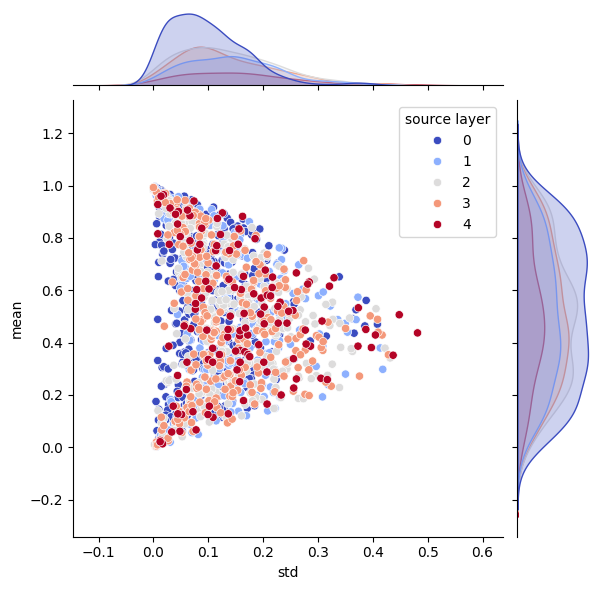

In [6]:
import seaborn as sns

sns.jointplot(plot_df, y="mean", x="std", hue="source layer", palette="coolwarm")